In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader


In [ ]:
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 30.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_batches = len(trainloader)
print(f" (batches): {num_batches}")


 (batches): 782


In [ ]:
for data, target in trainloader:
    print(data.shape)
    print(target.shape)
    break


torch.Size([64, 3, 224, 224])
torch.Size([64])


In [ ]:
original_model=resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.8MB/s]


In [ ]:
layer=list(original_model.children()  )[:-4]

In [ ]:
model_=nn.Sequential(*layer)

In [ ]:
class ExtendModel(nn.Module):
  def __init__(self,backbone):
    super(ExtendModel,self).__init__()
    self.backbone=backbone
    self.fc_layers = nn.Sequential(
              nn.Linear(512 * 28 * 28, 265),
              nn.ReLU(),
              nn.Linear(265, 128),
              nn.ReLU(),
              nn.Linear(128, 10)
          )

  def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ExtendModel(model_).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch} Batch: {batch_idx} Loss: {loss.item()}")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Accuracy: {(correct / total) * 100:.2f}%")


Using device: cuda
Epoch: 0 Batch: 0 Loss: 2.3041741847991943
Epoch: 0 Batch: 100 Loss: 1.4518804550170898
Epoch: 0 Batch: 200 Loss: 1.1393629312515259
Epoch: 0 Batch: 300 Loss: 1.0891059637069702
Epoch: 0 Batch: 400 Loss: 0.7838640213012695
Epoch: 0 Batch: 500 Loss: 0.7153134346008301
Epoch: 0 Batch: 600 Loss: 0.8576794862747192
Epoch: 0 Batch: 700 Loss: 0.7906757593154907
Epoch: 1 Batch: 0 Loss: 0.6724599003791809
Epoch: 1 Batch: 100 Loss: 0.6829601526260376
Epoch: 1 Batch: 200 Loss: 0.7829577326774597
Epoch: 1 Batch: 300 Loss: 0.5319608449935913
Epoch: 1 Batch: 400 Loss: 0.8437992930412292
Epoch: 1 Batch: 500 Loss: 0.7905243635177612
Epoch: 1 Batch: 600 Loss: 0.6139709949493408
Epoch: 1 Batch: 700 Loss: 0.6109506487846375
Epoch: 2 Batch: 0 Loss: 0.5109575390815735
Epoch: 2 Batch: 100 Loss: 0.5450770258903503
Epoch: 2 Batch: 200 Loss: 0.522771418094635
Epoch: 2 Batch: 300 Loss: 0.24916554987430573
Epoch: 2 Batch: 400 Loss: 0.3258582055568695
Epoch: 2 Batch: 500 Loss: 0.54560822248458

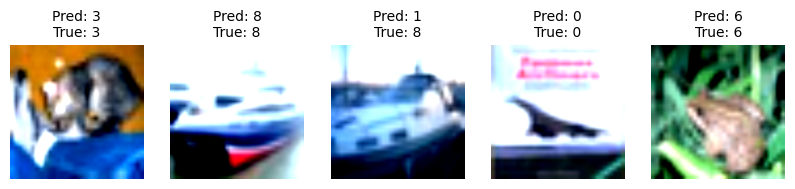

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

def imshow(img):
    img = img.cpu().numpy()
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis("off")

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i])
    plt.title(f"Pred: {predicted[i].item()}\nTrue: {labels[i].item()}", fontsize=10)
    plt.axis("off")

plt.show()